# Naive Bayes

## 1. Classifying Digits
In this part we will test digits classification on the MNIST dataset, using Bernoulli Naive Bayes (a generative model).

The MNIST dataset contains 28x28 grayscale images of handwritten digits between 0 and 9 (10 classes). For mathmatical analysis clarity, and for matching expected API, flatten each image to create a 1D array with 784 elements.

### Loading the MNIST dataset
Load the MNIST data set. The digits dataset is one of datasets scikit-learn comes with that do not require the downloading of any file from some external website. Use 
>```
mnist = sklearn.datasets.fetch_mldata('MNIST original')
```

to fetch the original data. You may set the `data_home` to where you wish to download your data for caching. Each image is already transformed into a 1D integer array $x\in [0,255]^{784}$, and the corresponding label is an integer $y\in [0,9]$.

Plot a single sample of each digit as the original image, so you get a feeling how the data looks like.

Finally, divide your data into train and test sets, using 1/7 of the data for testing.

---
**Note 1:** Using `digits = sklearn.datasets.load_digits()` will only fetch a very small sample of the original set, with images resized to 8x8. This preprocessing of the data reduces dimensionality and gives invariance to small distortions - however, we will use the original data in this exercise. Feel free to test the proformance of the algorithms below on the preprocessed data as well.

**Note 2:**
Since ML-Data is deprecated, you may wish to use something like this:
>```
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], 784)
x_test = x_test.reshape(x_test.shape[0], 784)
  ```



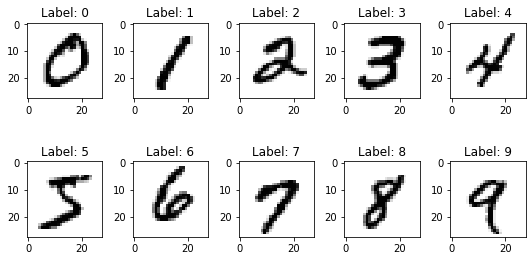

In [3]:
import numpy as np
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
%matplotlib inline

#load data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

#Plot a single sample of each digit
indexes = [1,3, 5,7,9,0,13,15,17,4]
fig, axes = plt.subplots(2, 5, figsize=(1.5*5,2*2))
count_rows = 0
count_columns = 0
for i in indexes:
    ax = axes[count_rows, count_columns]
    ax.imshow(x_train[i], cmap='gray_r')
    ax.set_title('Label: {}'.format(y_train[i]))
    count_columns +=1
    if count_columns == 5:
        count_columns = 0
        count_rows+=1
plt.tight_layout()
plt.show()

#divide your data into train and test sets
x_train = x_train.reshape(x_train.shape[0], 784)
x_test = x_test.reshape(x_test.shape[0], 784)

### Bernoulli Naive Bayes
If we know how the digits are generated, then we know how to classify them (simply choose the digit class which will maximize the posterior probability) --- but which model should we use for describing the digits generation?

In this part we will try a very simplified model of digits creation (which is obviously not the same as the "real" model), using a Naive Bayes over an underlying Bernoulli distribution --- that is, we will assume that given a digit class, the pixels of the images are the result of independent coin flips, each with its own "head" probability.

Note that since we assume each pixl is either 0 (black) or 1 (white), we will need to adjust (preprocess) our data accrodingly (see below).

So, the model is stated as follows:
$$
\begin{align}
\text{Domain} && x \in \{0,1\}^{784} \\
\text{Prior} && \pi_j = \Pr(y=j) \\
\text{Likelihood} && P_j(x) = \Pr(x | y=j) \\
\end{align}
$$

Where for each $i\in 0\ldots 784$ it holds that
$$
P_{ji}(x_i) = \Pr(x_i | y=j) =
\begin{cases}
p_{ji} & \text{if } x_i=1 \\
1-p_{ji} & \text{if } x_i=0 \\
\end{cases}
$$


#### Question 1
Write the classification rule based on this Naive Bayes model. 
How would you esitmate each of the parameters of the model based on the trainning data? 


**Bonus:** Think of edge cases which may effect your estimator in an undesired way.

#### Answer 1

In [4]:

class BernoulliNaiveBayes(object):
    
    def __init__(self, alpha=1):
        self.p_prior = []
        self.p_likelihood = []
        self.x_train = []
        self.y_train = []
        self.n_labels = 0
        self.n_features = 0
        self.alpha = alpha
        
    def fit(self, x_train, y_train):
        self.x_train = np.where(x_train>0, 1, x_train)
        self.y_train = y_train
        self.n_features = self.x_train.shape[1]
        self.calc_prior_prob()
        self.calc_likelihood_prob()
        
    def calc_prior_prob(self):
        y_labels, counts = np.unique(self.y_train, return_counts=True)
        self.n_labels = len(y_labels)
        number_of_samples = self.y_train.shape[0]
        probs_labels = counts/number_of_samples
        self.p_prior = probs_labels
        
    def calc_likelihood_prob(self):
        self.p_likelihood = np.zeros([self.n_labels, self.n_features])
        
        for label in range(self.n_labels):
            X_filtered = self.x_train[(self.y_train == label), :]
            number_of_shows = (X_filtered.sum(axis = 0) + self.alpha)
            number_of_opptions = (X_filtered.shape[0] + 2 * self.alpha)
            self.p_likelihood[label, :] = number_of_shows / number_of_opptions
            
    def predict(self, x_test):
        x_test = np.where(x_test>0, 1, x_test)
        y_predict = []
        
        for row_index in range(x_test.shape[0]):
            sample = x_test[row_index]
            probs_one_feature = np.prod(self.p_likelihood[:, sample==1], axis=1)
            probs_zero_feature = np.prod((1-self.p_likelihood[:, sample==0]),axis=1)
            prob_by_label = probs_one_feature * probs_zero_feature * self.p_prior
            y_label = np.argmax(prob_by_label)
            y_predict.append(y_label)
        return y_predict

#### Question 2
Run a Naive Bayes classifier on the training data and apply predictions on the test data. Use the [sklearn.naive_bayes.BernoulliNB](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html) implementation (see the [source code for sklearn.naive_bayes](https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/naive_bayes.py) for details).

Remember we need to preprocess the data in this case such that each pixel would become either black (0) or white (1). For this, use the `binarize` parameter of the implementation. Set this value to $0$ (this is the default), which in this case would mean every pixel with non-zero value will be set to 1.

1. Plot the mean image of each class (estimated $\hat{p}_{ji}$) and generate one sample of each class (remember, you can do this since this is a generative model). You will need to access the `feature_log_prob_` attribute of the trained model.

2. Plot the confusion matrix of your classifier, as claculated on the test data (it is recommended to use [sklearn.metrics.confusion_matrix](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)). Calculate the total accuracy (fraction of correctly classified images), and summarize the results in your own words.

3. Think of a way you can find the optimal threshold of the binarization part. **There is no need to actually perform this task --- just describe what you would have done.**


#### Answer 2

In [5]:
from sklearn.naive_bayes import BernoulliNB

clf = BernoulliNB(binarize=0).fit(x_train, y_train)
clf.predict(x_test)

array([7, 2, 1, ..., 9, 8, 6], dtype=uint8)

In [6]:
def create_digits(labels, p_for_feature_label):
    count_rows = 0
    count_columns = 0
    label = -1
    fig, axes = plt.subplots(2, 5, figsize=(1.5*5,2*2))

    for label in labels:
        features_list = np.array(p_for_feature_label[label]).reshape(28,28)
        ax = axes[count_rows, count_columns]
        ax.imshow(features_list, cmap='gray_r')
        ax.set_title('Label: {}'.format(label))
        count_columns +=1
        if count_columns == 5:
            count_columns = 0
            count_rows+=1
    plt.tight_layout()
    plt.show()

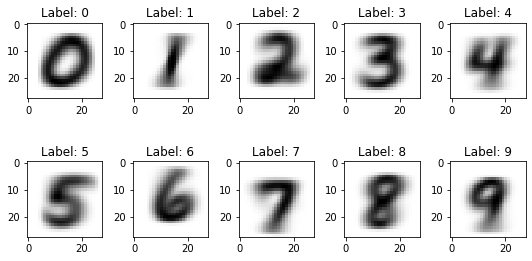

In [7]:
#Plot the mean image of each class
labels = np.unique(y_train)
x_train = np.where(x_train>0, 1, x_train)
p_for_feature_label = np.zeros([labels.shape[0], x_train.shape[1]])

for label in labels:
    X_filtered = x_train[(y_train == label), :]
    mean_features = (X_filtered.mean(axis = 0))
    p_for_feature_label[label, :] = mean_features
create_digits(labels, p_for_feature_label)                       

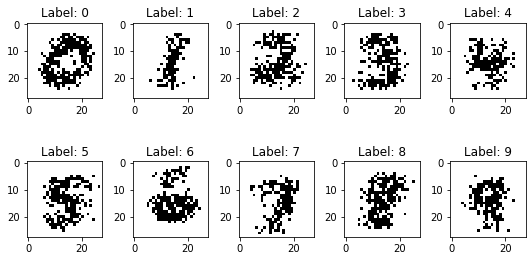

In [8]:
#generate one sample of each class
empirical_probs_of_features = np.exp(clf.feature_log_prob_)
lables = np.unique(y_train)
p_for_feature_label = np.zeros([lables.shape[0], x_train.shape[1]])

for label in lables:
    features = []
    digit_label = empirical_probs_of_features[label]
    for prob_feature in digit_label:
        feature_result = np.random.binomial(1, prob_feature, size=None)
        features.append(feature_result)
    p_for_feature_label[label, :] = np.array(features)

create_digits(labels, p_for_feature_label)

In [9]:
#confusion matrix of your classifier, Calculate the total accuracy
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

bernouli_naive_base_obj = BernoulliNB(alpha=1)
bernouli_naive_base_obj.fit(x_train, y_train)
y_predict = bernouli_naive_base_obj.predict(x_test)
print(f'Accuracy score: {accuracy_score(y_test, y_predict)}')
print(confusion_matrix(y_test, y_predict))

Accuracy score: 0.8413
[[ 887    0    4    7    2   41   16    1   22    0]
 [   0 1085   10    5    0    9    6    0   19    1]
 [  19    8  852   29   17    4   32   14   55    2]
 [   5   15   34  844    0   13    9   15   49   26]
 [   2    6    4    0  795    4   21    1   23  126]
 [  23   12    7  129   30  627   16    8   21   19]
 [  18   18   15    2   13   35  851    0    6    0]
 [   1   24   14    4   15    0    0  871   27   72]
 [  16   23   13   76   17   22    7    6  758   36]
 [   9   13    5    9   74    8    0   24   24  843]]


#### Summarize the results
The accuracy score is 0.8413 which isan high score but not very accurate. As we can see from the confusion matrix, the primer diagnol represent the rigth predictions of each digit. From this diagnol we can see that the most accurate predictions were on digit 1 with 1085 right predections. Also we can see that probably the features of 4,9 and 5,3 are similar because the algorithem predected 4 as 8 above of the average mistake, and same with 5 that the predection was 3.

#### A way to find the optimal threshold of the binarization
If we look at the original data we can see that there are some range of numbers that repeat on themself in the features. for example: features with values betwwen 200-253 which are clearly dark colors or values between 3-25 which are clearly bright colors. So a good way to find the optimal is to split those values to bins and show them on histogram and find the mean value of the histogram and make it the binarization value.
In this way we will get that feature that are pretty bright will mark as 0 and the dark colors that re for sure features of 1 get this value.

## 2. Classifing Text Documents using Multinomial Naive Bayes
In this exercise you will classify the "20 newsgroups" data set using your own naive bayes classifier and compare to the scikit learn built in version.

The 20 newsgroups dataset comprises around 18000 newsgroups posts on 20 topics split in two subsets: one for training (or development) and the other one for testing (or for performance evaluation). The split between the train and test set is based upon messages posted before and after a specific date.


* Load the **train** data using `from sklearn.datasets import fetch_20newsgroups`. remove headers, footers and quotes (see documentation)
* Use `sklearn.feature_extraction.text import CountVectorizer` to count words (stop_words='english')
* Write a class `NaiveBayes(BaseEstimator, ClassifierMixin)` and implement its `fit`, `predict` and `predict_proba` methods.
* use `sklearn.pipeline.make_pipeline` to chain the vectroizer and model.
* note: limit the vocuabolary size if you suffer memory issues
* compare the accuracy over the **test** data. You can use `accuracy_score, classification_report`
* compare to the built in `sklearn.naive_bayes.MultinomialNB`. If there are differences try to think why
* plot the learning curve - is the model in the bias or variance regime (you can use the built in model for doing the analysis)
* optimize performance in respect to vectorizer hyper parameters (e.g. max_features, max_df etc.).

### Optional: Model interpretability
Find the most important features for a **specific** decision of a NB classifier.
Because the model has learned the prior $p(x_i|c)$ during the training, the contribution of an individual feature value can be easily measured by the posterior, $p(c|x_i)=p(c)p(x_i|c)/p(x_i)$
Implement a function which gets a scikit-learn NB model as input and returns $P(c|x_i)$:

`def calc_p_c_given_xi(model)`

Hint: Use the following model properties:

* `model.class_log_prior_`
* `model.feature_log_prob_`

Note: remember these are logs and you need to use np.exp and normalize to get $P(c|x_i)$ 
Another hint: use numpy built-in broadcasting property.

* Use the interpretation to examine errors of the classifier where $\hat{c}\ne c$. Which top words support the correct class and which support the wrong class? You can use the `print_txt` below to color words. 

Bonus: How can you correct the analyzed error? 

To read more about model interpretation, see the blogpost below and my tutorial:
* https://lilianweng.github.io/lil-log/2017/08/01/how-to-explain-the-prediction-of-a-machine-learning-model.html
* https://github.com/chanansh/right_but_why

In [8]:
#Load the train data and count words
#CountVectorizer, which builds a dictionary of features and transforms documents to feature vectors:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer

twenty_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
twenty_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))

x_train = twenty_train.data
x_test = twenty_test.data
y_train = twenty_train.target
y_test = twenty_test.target

In [9]:
#Write a class NaiveBayes(BaseEstimator, ClassifierMixin)
from sklearn.base import BaseEstimator, ClassifierMixin

class NaiveBayes(BaseEstimator, ClassifierMixin):
    
    def __init__(self, alpha=1.0):
        self.prior = []
        self.features_proba = []
        self.alpha = alpha

    def fit(self, x_train, y_train):
        self.calc_prior_probs(y_train)
        self.calc_feature_probs(x_train, y_train)
        
    def calc_prior_probs(self, y_train):
        y_labels, counts = np.unique(y_train, return_counts=True)
        number_of_samples = y_train.shape[0]
        probs_labels = counts/number_of_samples
        self.prior = probs_labels
        
    def calc_feature_probs(self, x_train, y_train):
        labels, counts = np.unique(y_train, return_counts=True)
        n_features = x_train.shape[1]
        self.features_proba = np.zeros([len(labels), n_features])
        
        for label in labels:
            X_filtered = x_train[(y_train == label), :]
            number_of_features_shows = X_filtered.sum(axis=0) + self.alpha
            number_of_opptions = X_filtered.sum() + n_features * self.alpha
            self.features_proba[label, :] = number_of_features_shows / number_of_opptions
        
    def predict(self, x_test):
        x_test = x_test.toarray()
        y_options_probs = self.predict_log_proba(x_test)
        y_predict = np.argmax(y_options_probs, axis=1)
        return y_predict
        
    def predict_log_proba(self, x_test):
        y_prediction = [] 
        for row_index in range(x_test.shape[0]):
            document_words = x_test[row_index]
            indexes = np.where(document_words!=0)[0]
            relevant_features = self.features_proba[:,indexes]
            relevant_words = document_words[indexes]
            feature_by_occuracy = np.log(relevant_words*relevant_features).sum(axis=1)
            prob_by_label = feature_by_occuracy + np.log(self.prior)
            y_prediction.append(prob_by_label)
        return y_prediction

In [10]:
from sklearn.pipeline import Pipeline

text_clf =  Pipeline([('vect', CountVectorizer(stop_words='english')),('naiveBayes', NaiveBayes())])
text_clf.fit(x_train, y_train)
y_predict = text_clf.predict(x_test)

print('accuracy', accuracy_score(y_test, y_predict))
print(classification_report(y_test, y_predict))
print('confusion matrix\n', confusion_matrix(y_test, y_predict))

accuracy 0.6192246415294742
              precision    recall  f1-score   support

           0       0.61      0.26      0.36       319
           1       0.59      0.66      0.62       389
           2       0.25      0.00      0.01       394
           3       0.55      0.71      0.62       392
           4       0.76      0.55      0.64       385
           5       0.56      0.80      0.66       395
           6       0.87      0.68      0.76       390
           7       0.82      0.66      0.73       396
           8       0.90      0.59      0.71       398
           9       0.93      0.72      0.81       397
          10       0.58      0.88      0.70       399
          11       0.51      0.79      0.62       396
          12       0.70      0.46      0.56       393
          13       0.80      0.77      0.78       396
          14       0.70      0.75      0.72       394
          15       0.44      0.89      0.58       398
          16       0.57      0.62      0.59       364

In [11]:
from sklearn.naive_bayes import MultinomialNB

text_clf =  Pipeline([('vect', CountVectorizer(stop_words='english')),('naiveBayesmodel', MultinomialNB())])
text_clf.fit(x_train, y_train)
y_predict_sklearn_model = text_clf.predict(x_test)

print('accuracy', accuracy_score(y_test, y_predict_sklearn_model))
print(classification_report(y_test, y_predict_sklearn_model))
print('confusion matrix\n', confusion_matrix(y_test, y_predict_sklearn_model))

accuracy 0.6343600637280935
              precision    recall  f1-score   support

           0       0.65      0.30      0.41       319
           1       0.58      0.69      0.63       389
           2       0.40      0.01      0.01       394
           3       0.53      0.72      0.61       392
           4       0.74      0.56      0.64       385
           5       0.56      0.81      0.66       395
           6       0.85      0.69      0.76       390
           7       0.82      0.70      0.76       396
           8       0.91      0.62      0.73       398
           9       0.94      0.74      0.83       397
          10       0.58      0.91      0.71       399
          11       0.54      0.79      0.64       396
          12       0.71      0.49      0.58       393
          13       0.81      0.79      0.80       396
          14       0.72      0.75      0.73       394
          15       0.46      0.91      0.61       398
          16       0.57      0.61      0.59       364

#### If there are differences try to think why
answer: The results of the 2 models are almost the same, our model has an accuracy of 0.62 and the sklearn model got 0.64 accuracy score. The avg scores of f1, recall, precision are almost the same, there is a shifting of 0.02 difference between the results and the confusion matrix represent the same patterns of mistakes. 
So We can say that probably the difference between the 2 models is in the implementation of the calculation of the predict probs and when we oerate the log function. As we can see, in the sklearn documentation the feature probs already saves as "feature_log_prob_" and in our model we operate the logs only by demand of the feature probs, maybe the numbers we got are less accurate and create mistakes in recognize the document category.

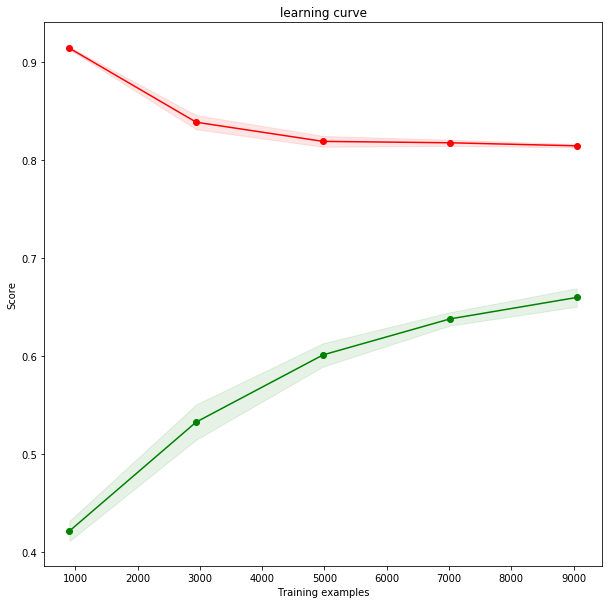

In [12]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, X, y,cv=None, n_jobs=None, train_sizes=np.linspace(0.1, 1.0, 5)):
    plt.figure(figsize=(10,10))
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.title("learning curve")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(estimator,X,y,cv=cv,n_jobs=n_jobs,
        train_sizes=train_sizes,return_times=True)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    plt.fill_between(train_sizes,train_scores_mean - train_scores_std,train_scores_mean + train_scores_std,
        alpha=0.1,color="r")
    plt.fill_between(train_sizes,test_scores_mean - test_scores_std,test_scores_mean + test_scores_std,
        alpha=0.1,color="g")
    plt.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score")
    return plt

count_vect = CountVectorizer(stop_words='english').fit(twenty_train.data)
X = count_vect.transform(twenty_train.data)
plot_learning_curve(NaiveBayes(), X, y_train, cv=5, n_jobs=4)

plt.show()

#### Is the model in the bias or variance regime?
Answer: From the curve, we can clearly see that as the size of the training set increases,the cross-validation accuracy increases. So adding training data is useful in this case. The training score accuracy is going down when we are increasing the size of training data. This means that our model has high bias and low variance, because the accuracy of cross validation is not high- meaning we have bias, and the accuracy of the train is not very high- meaning our variance is low. To achieve lower bias, we can add more training data and it might improve our model.

In [13]:
#improve vectorize:

text_clf =  Pipeline([('vect', CountVectorizer(stop_words='english',max_df=0.1, max_features = 40000)),('naiveBayes', NaiveBayes())])
text_clf.fit(x_train, y_train)
y_predict = text_clf.predict(x_test)

print('accuracy', accuracy_score(y_test, y_predict))

accuracy 0.6525491237387148


In [14]:
import string
def print_txt(txt, hot, cold):
  """
  print the text, coloring hot and cold words with colors
  """
  cold_color='\x1b[41;37m{}\x1b[0m'
  hot_color='\x1b[42;37m{}\x1b[0m'
  def color(token):
    lower = str(token).lower()
    lower = lower.replace('\t','').replace('\n','')
    lower = lower.translate(string.punctuation)
    if (lower in hot) and (lower in cold):
      return mid_color.format(token)
    elif lower in hot:
      return hot_color.format(token)
    elif lower in cold:
      return cold_color.format(token)
    else:
      return token
  colored_txt = " ".join([color(token) for token in txt.split(' ')])
  print(colored_txt)
print_txt('This word support the first class but this the other', ['word'],['other'])

This word support the first class but this the other
